# Starter Notebook: Fruit Classification Challenge

This notebook provides the train, testing, and validation data loaders.

Through the following link, you can access a private Kaggle challenge on fruit classification:

https://www.kaggle.com/t/b4dbb9add11c4da0962b837929799d52

## Challenge
Build a model to classify images of bananas, apples, and oranges as fresh or rotten.
Dataset

* Training set: 1,058 labeled images across fruit types
* Test set: 453 images (hidden labels)
* Resolution: varied, RGBA format

## Build a Model and a Training/Validation Loop

You can use the following code as a starting point for the challenge. See if you can achieve over 92% accuracy.


In [38]:
!cp kaggle.json /root/.config/kaggle
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c fruit-classification

fruit-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [39]:
!unzip fruit-classification.zip

Archive:  fruit-classification.zip
  inflating: sample_submission.csv   
replace test/test/test_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/test/test_1.png    
  inflating: test/test/test_10.png   
  inflating: test/test/test_100.png  
  inflating: test/test/test_101.png  
  inflating: test/test/test_102.png  
  inflating: test/test/test_103.png  
  inflating: test/test/test_104.png  
  inflating: test/test/test_105.png  
  inflating: test/test/test_106.png  
  inflating: test/test/test_107.png  
  inflating: test/test/test_108.png  
  inflating: test/test/test_109.png  
  inflating: test/test/test_11.png   
  inflating: test/test/test_110.png  
  inflating: test/test/test_111.png  
  inflating: test/test/test_112.png  
  inflating: test/test/test_113.png  
  inflating: test/test/test_114.png  
  inflating: test/test/test_115.png  
  inflating: test/test/test_116.png  
  inflating: test/test/test_117.png  
  inflating: test/test/test_118.png  
  inflating: test/tes

In [40]:
!mkdir fruit-classification
!mv test train train.csv sample_submission.csv fruit-classification/

mkdir: cannot create directory ‘fruit-classification’: File exists
mv: cannot move 'test' to 'fruit-classification/test': Directory not empty
mv: cannot move 'train' to 'fruit-classification/train': Directory not empty


In [41]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define constants
TRAIN_CSV_PATH = '/content/fruit-classification/train.csv'
TRAIN_IMG_DIR = '/content/fruit-classification/train/train'
TEST_IMG_DIR = '/content/fruit-classification/test/test'
BATCH_SIZE = 128
SEED = 42
VALIDATION_SPLIT = 0.2

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),A
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class for the training and validation datasets (with labels)
class FruitDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        # Create a label mapping for classification
        self.classes = ['fresh_apple', 'fresh_banana', 'fresh_orange',
                        'rotten_apple', 'rotten_banana', 'rotten_orange']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Id']
        label = self.df.iloc[idx]['Label']
        img_path = os.path.join(self.img_dir, img_name)

        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert text label to numeric index
        label_idx = self.class_to_idx[label]

        return image, label_idx

# Class for the test dataset (without labels)
class TestFruitDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name  # Return image name as identifier instead of label

def create_dataloaders():
    # Read the training data CSV
    train_df = pd.read_csv(TRAIN_CSV_PATH)

    # Split into train and validation sets
    train_df, val_df = train_test_split(
        train_df, test_size=VALIDATION_SPLIT, random_state=SEED,
        stratify=train_df['Label']  # Stratify to maintain class distribution
    )

    # Create datasets
    train_dataset = FruitDataset(train_df, TRAIN_IMG_DIR, transform=train_transforms)
    val_dataset = FruitDataset(val_df, TRAIN_IMG_DIR, transform=val_test_transforms)
    test_dataset = TestFruitDataset(TEST_IMG_DIR, transform=val_test_transforms)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )

    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )

    return train_loader, val_loader, test_loader, train_dataset.classes

# Function to visualize a batch of images
def visualize_batch(dataloader, classes=None, n=8):
    images, labels = next(iter(dataloader))
    images = images[:n]  # Take only n images

    # Move to CPU and convert to numpy for visualization
    images = images.cpu().numpy()

    # Denormalize images for better visualization
    images = np.transpose(images, (0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    # Plot images in a grid
    fig, axes = plt.subplots(2, n//2, figsize=(15, 8))
    axes = axes.flatten()

    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        if classes and isinstance(labels, torch.Tensor):
            ax.set_title(f"Label: {classes[labels[i].item()]}")
        elif not isinstance(labels, torch.Tensor):
            # For test datasets where labels are filenames
            ax.set_title(f"File: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [42]:
train_loader, val_loader, test_loader, classes = create_dataloaders()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [43]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")
print(f"Classes: {classes}")

Number of training batches: 7
Number of validation batches: 2
Number of test batches: 4
Classes: ['fresh_apple', 'fresh_banana', 'fresh_orange', 'rotten_apple', 'rotten_banana', 'rotten_orange']


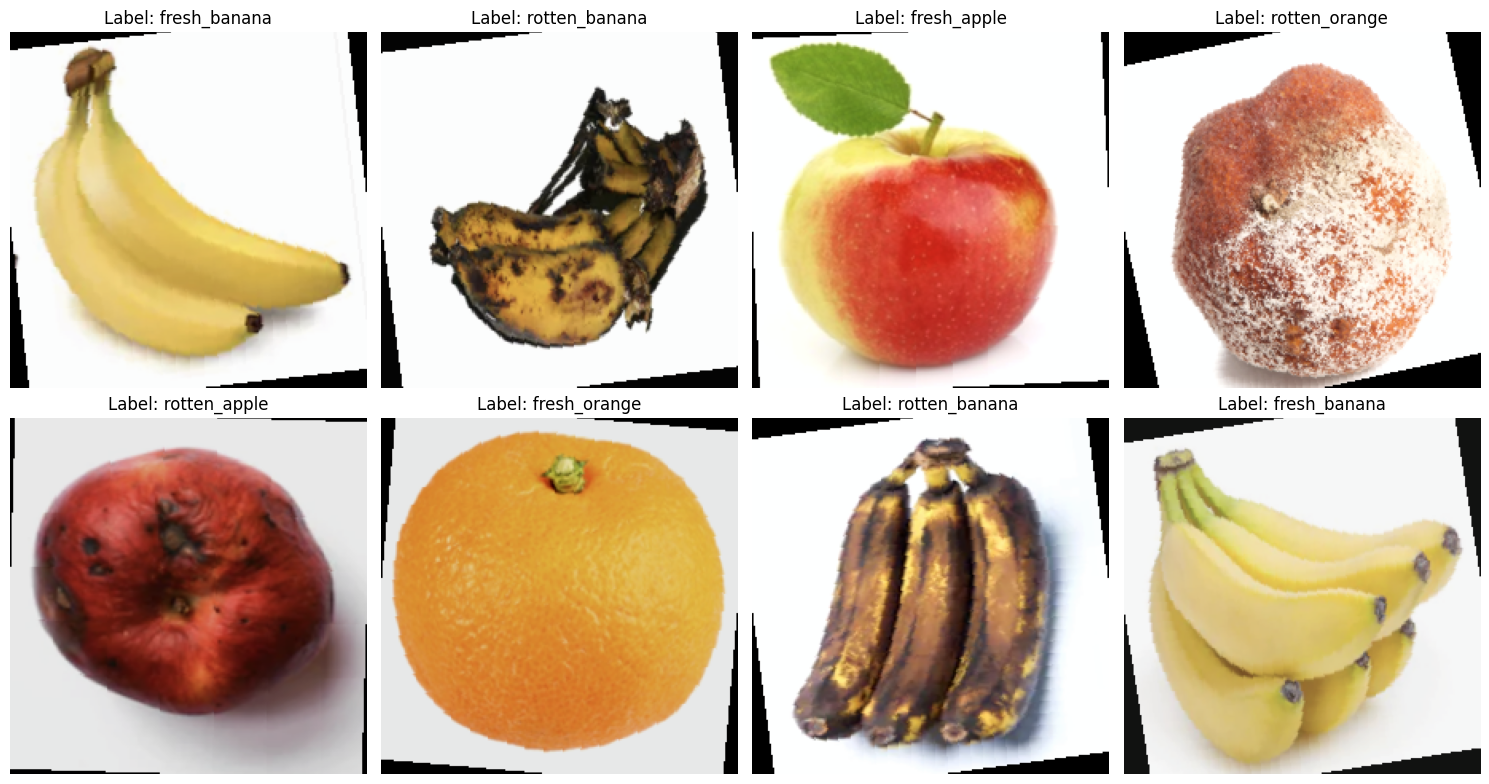

In [44]:
# # Visualize a batch from the train_loader
visualize_batch(train_loader, classes)  # Training samples with augmentation


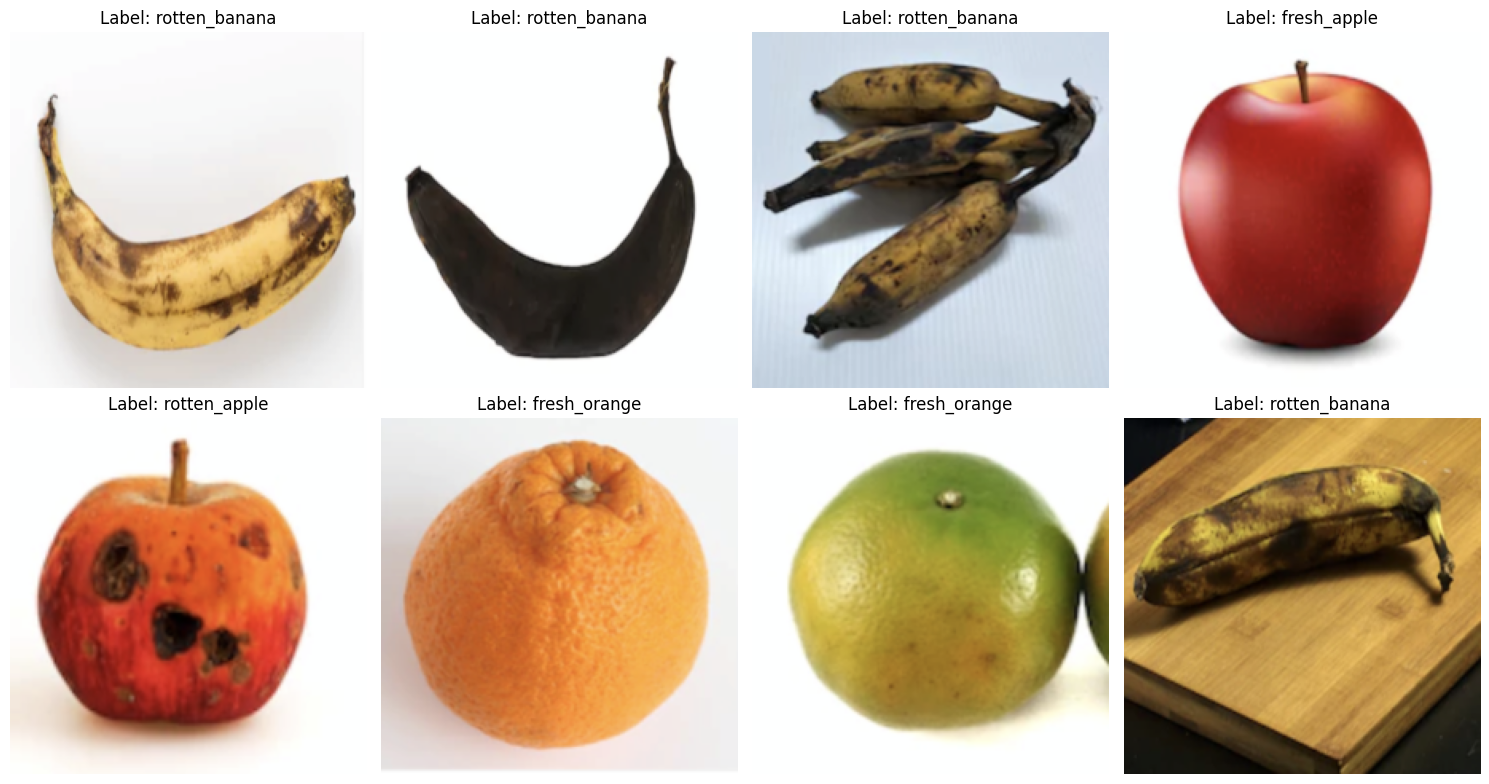

In [45]:
visualize_batch(val_loader, classes)  # Validation samples, no augmentation


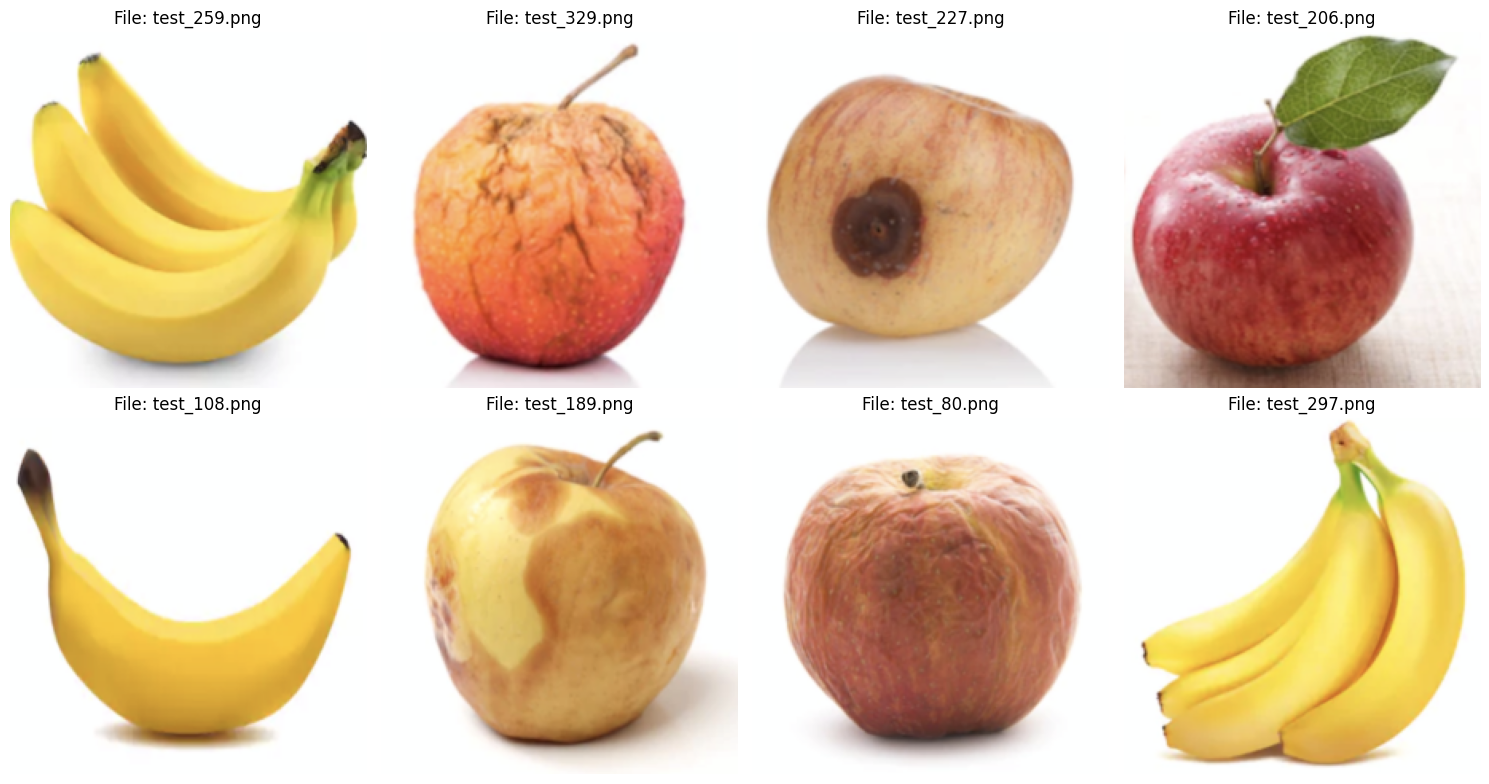

In [46]:
visualize_batch(test_loader, classes)  # Test samples, no augmentation


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet18 model
model = models.resnet50(pretrained=True)
model.requires_grad_(True)

# Modify the final fully connected layer for 6 output classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    model.fc,
    nn.ReLU(),
    nn.Linear(1000, 6)
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

      # Validation
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      print(f"Validation Accuracy: {100 * correct / total}%")

Epoch 1/100, Loss: 0.8138648654733386
Validation Accuracy: 51.41509433962264%
Epoch 11/100, Loss: 0.05973459354468754
Validation Accuracy: 93.86792452830188%
Epoch 21/100, Loss: 0.08186963413442884
Validation Accuracy: 83.01886792452831%
Epoch 31/100, Loss: 0.021113396622240543
Validation Accuracy: 96.22641509433963%
Epoch 41/100, Loss: 0.04214576618479831
Validation Accuracy: 91.98113207547169%
Epoch 51/100, Loss: 0.02361605888498681
Validation Accuracy: 96.69811320754717%
Epoch 61/100, Loss: 0.004032236058264971
Validation Accuracy: 98.11320754716981%
Epoch 71/100, Loss: 0.13179754678692138
Validation Accuracy: 91.98113207547169%
Epoch 81/100, Loss: 0.05267076074544873
Validation Accuracy: 94.33962264150944%
Epoch 91/100, Loss: 0.015065577812492847
Validation Accuracy: 96.22641509433963%


In [50]:
import pandas as pd

# Prediction loop for test data
model.eval()
predictions = []
image_names = []

with torch.no_grad():
    for inputs, img_name in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        image_names.extend(img_name)

# Create a DataFrame for the predictions
submission_df = pd.DataFrame({'Id': image_names, 'Label': predictions})


#connvert lables to strinngs uing classes array
submission_df['Label'] = submission_df['Label'].apply(lambda x: classes[x])

#save submission_df to csv file
submission_df.to_csv('submission.csv', index=False)
submission_df

,Id,Label
0,test_259.png,fresh_banana
1,test_329.png,rotten_apple
2,test_227.png,rotten_apple
3,test_206.png,fresh_apple
4,test_108.png,fresh_banana
...,...,...
448,test_363.png,fresh_banana
449,test_92.png,rotten_apple
450,test_211.png,fresh_apple
451,test_208.png,fresh_apple


In [51]:
!kaggle competitions submit -c fruit-classification -f submission.csv -m "Rs50_100ep_last_layer_replace"

100% 11.5k/11.5k [00:00<00:00, 34.9kB/s]
Successfully submitted to Fruit classification